# Multi-class suport vector machine (SVM)

We'll fit a multi-class linear SVM on red wine with the typical train/validate workflow. 

SVM only supports binary classification by itself. The multiclass support can be handled according to a one vs one or a one vs rest scheme. (http://scikit-learn.org/stable/modules/classes.html#module-sklearn.multiclass)

Here, we'll use the single class linear SVM from Tensorflow and construct a one vs one multiclass SVM based on that. 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import os, sys
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
datasource = "datasets/winequality-red.csv"
print(os.path.exists(datasource))

True


In [5]:
dataset = pd.read_csv(datasource).sample(frac = 1).reset_index(drop = True)
del dataset["Unnamed: 0"]

In [6]:
dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,11.3,0.34,0.45,2.0,0.082,6.0,15.0,0.99880,2.94,0.66,9.2,6
1,11.6,0.41,0.58,2.8,0.096,25.0,101.0,1.00024,3.13,0.53,10.0,5
2,10.6,0.44,0.68,4.1,0.114,6.0,24.0,0.99700,3.06,0.66,13.4,6
3,9.3,0.36,0.39,1.5,0.080,41.0,55.0,0.99652,3.47,0.73,10.9,6
4,6.6,0.70,0.08,2.6,0.106,14.0,27.0,0.99665,3.44,0.58,10.2,5


In [7]:
selected_features = [1, 6, 9, 10]

In [8]:
X = scale(np.array(dataset.iloc[:, selected_features]))
y = np.array(dataset["quality"])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [10]:
dataset.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


## Create multi-class SVM model

Create an array containing names of the feature columns.

In [11]:
feature_names = [dataset.columns[i].replace("\x20", "_") for i in selected_features] # \x20 is a space
print(feature_names)

['volatile_acidity', 'total_sulfur_dioxide', 'sulphates', 'alcohol']


Create feature columns, which is similar to tensorflow placeholders that takes data from training loop. They must be fed training data during training. 

In [13]:
feature_columns = [tf.contrib.layers.real_valued_column(i) for i in feature_names]

## Note:

One vs one multi-class SVM is essentially a collection of binary linear SVMs, each created for predicting a pair of classes against each other. Therefore, for each pair of classes, there needs to be an SVM. In other words, given 4 classes {A, B, C, D}, there will need to be the following classifiers. 

* A vs B
* A vs C
* A vs D
* B vs C
* B vs D
* C vs D

For N classes, it would be N choose 2, pair-wise classifiers

In [14]:
class_labels = np.unique(y_train)
print("Class distribution", {i: np.sum(y == i) for i in y_train})

Class distribution {5: 681, 6: 638, 4: 53, 7: 199, 8: 18, 3: 10}


In [15]:
class_pairs = [(i, j) for i, j in itertools.product(class_labels, class_labels) if j > i]
print("Class pairs", class_pairs)

Class pairs [(3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (4, 5), (4, 6), (4, 7), (4, 8), (5, 6), (5, 7), (5, 8), (6, 7), (6, 8), (7, 8)]


Now, we traverse all pairs of classes and create an SVM dedicated to each pair

In [17]:
classifiers = {
    pair: tf.contrib.learn.SVM("example_id", feature_columns = feature_columns, l2_regularization = 1.0)
        for pair in class_pairs
}

## Training and preparation

Accordingly, we are going to need an my_input_fn() for each SVM. It's done by creating the following function that returns an my_input_fn() for any given pair. 

In [18]:
def get_input_fn(pair):
    
    # subset out all relevant data to this pair of classes
    sample = np.logical_or(y_train == pair[0], y_train == pair[1])
    X_subset = X_train[sample, :]
    y_subset = y_train[sample] == pair[1]
    
    # creating my_input_fn() that works on a subset of training data
    def my_input_fn():
        columns = {
            feature_name: tf.constant(np.expand_dims(X_subset[:, i], 1))
                for i, feature_name in enumerate(feature_names)
        }
        
        columns["example_id"] = tf.constant([str(i + 1) for i in range(len(X_subset))])
        labels = tf.constant(y_subset)
        return columns, labels
    return my_input_fn, len(y_subset)

Fit all SVM classifiers. 

In [20]:
for pair in class_pairs:
    this_input_fn, sample_size = get_input_fn(pair)
    print("Fitting an SVM to classes", pair, "with", sample_size, "samples.")
    classifiers[pair].fit(input_fn = this_input_fn, steps = 30)

Fitting an SVM to classes (3, 4) with 43 samples.
Fitting an SVM to classes (3, 5) with 524 samples.
Fitting an SVM to classes (3, 6) with 478 samples.
Fitting an SVM to classes (3, 7) with 162 samples.
Fitting an SVM to classes (3, 8) with 16 samples.
Fitting an SVM to classes (4, 5) with 555 samples.
Fitting an SVM to classes (4, 6) with 509 samples.
Fitting an SVM to classes (4, 7) with 193 samples.
Fitting an SVM to classes (4, 8) with 47 samples.
Fitting an SVM to classes (5, 6) with 990 samples.
Fitting an SVM to classes (5, 7) with 674 samples.
Fitting an SVM to classes (5, 8) with 528 samples.
Fitting an SVM to classes (6, 7) with 628 samples.
Fitting an SVM to classes (6, 8) with 482 samples.
Fitting an SVM to classes (7, 8) with 166 samples.


## Evaluation

Below defines a set of functions that facilitate making predictions of this multi-class SVM

In [21]:
def svm_pred_to_class(predictions, pair):
    """ Convert SVM prediction into class labels
           1. Take 'classes' attribute from each prediction
           2. Use the binary prediction as index to find out original label from pair
           
        Example:
            a prediction of 1 resulting from an SVM dedicated to classes (3, 4)
            will be translated into 4, which is the original class label instead
            of binary label 0 or 1.
    """
    return list(map(lambda i: pair[i["classes"]], predictions))

In [23]:
def predict_fn():
    """ Prepare test data from X_test """
    return {
        feature_name: tf.constant(np.expand_dims(X_test[:, i], 1))
            for i, feature_name in enumerate(feature_names)
    }

In [24]:
def vote(labels):
    """ Aggregate prediction results from one-vs-one SVMs by counting votes per class """
    hist, bins = np.histogram(labels, class_labels)
    return bins[np.argmax(hist)]

In [25]:
def get_predictions(X_test):
    """ Make predictions using all SVMs and aggregrate results. """
    
    # make predictions with all SVMs and stack results in columns
    # this results in a matrix in shape (num_samples, num_class_pairs)
    
    predictions = np.column_stack([
        svm_pred_to_class(classifiers[pair].predict(input_fn = predict_fn), pair)
            for pair in class_pairs
    ])
    
    print("predictions", predictions.shape)
    
    # aggregate results along axis = 1 into a final prediction for each sample
    return np.array([vote(row) for row in predictions])

Now we make a prediction on the test dataset

In [26]:
y_pred = get_predictions(X_test)

predictions (400, 15)


Evaluate

Accuracy 0.5525


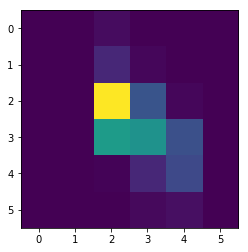

In [27]:
print("Accuracy", accuracy_score(y_test, y_pred))
plt.imshow(confusion_matrix(y_test, y_pred))